## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [42]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [43]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [44]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [45]:
len(df.user_id.unique())

290584

d. The proportion of users converted.

In [46]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [47]:
a = df.query('group == "treatment" & landing_page != "new_page"').shape[0]  
b = df.query ('group == "control" & landing_page != "old_page"').shape[0]
a + b

3893

f. Do any of the rows have missing values?

In [48]:
df.isnull().sum().sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [49]:
df2 = df
drop_a = df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page'))
                        == False]
c= drop_a.index.tolist()
df2=df2.drop(df2.index[c])

In [50]:
df.shape[0], df2.shape[0]

(294478, 290585)

In [51]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [52]:
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [53]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [54]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [55]:
df2 = df2.drop(1899)
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [56]:
df2.query('converted == 1').shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [57]:
df2.query('group=="control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [58]:
df2.query('group=="treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [59]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**Answer:** <br> 
<br>
**the conversion rate for the control group is 12.04% for the control group and 11.88% for the treatment group.
<br> what the numbers tells us is that there is no clear winner from both pages. The difference in conversion rates between the two pages is so small that we can not really conclude that the old old page is the page that will keep leading to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

>**Answer:** <br>
<br>
**The null hypothesis is what we assume to be the truth before analyzing any data. the alternative hypothesis is what we hope to be true. <br>
In this case, we assume (the null hypothesis) that the old page has a better or equal conversion rate** **$p_{old}$** **than the new page** **$p_{new}$**. 
<br> **The alternative hypotheses will be that the new page has a conversion rate** **$p_{new}$** **that is higher than the old page's** **$p_{old}$**. 

 ><br> **The null is Ho** : **$p_{new}$** - **$p_{old}$**  ≤  0


>**The Alternative Hypothesis H1** : **$p_{new}$** - **$p_{old}$** > 0




`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [60]:
p_new = df.query('converted == 1').shape[0]/df.shape[0]
p_new

0.11965919355605512

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [61]:
p_old = df.query('converted == 1').shape[0]/df.shape[0]
p_old

0.11965919355605512

c. What is $n_{new}$?

In [62]:
new = df2.query('group=="treatment"')
n_new = new.shape[0]
n_new

145310

d. What is $n_{old}$?

In [63]:
old = df2.query('group=="control"')
n_old = old.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [64]:
new_page_converted =  np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.1201706696029179

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [65]:
old_page_converted= np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted.mean()

0.11928493742858323

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [66]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

0.00088573217433467188

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [67]:
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

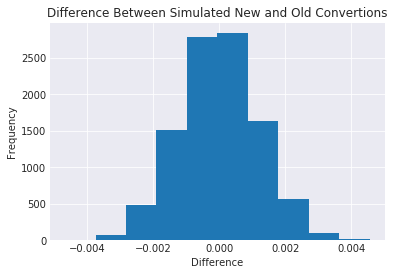

In [68]:
p_diffs = np.asarray(p_diffs)
plt.hist(p_diffs);
plt.title('Difference Between Simulated New and Old Convertions')
plt.xlabel('Difference')
plt.ylabel('Frequency');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [69]:
(p_diffs > obs_diff).mean()

0.22370000000000001

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**
<br> **In part j, we calculate the proportion of p_diffs that are greater than the observed difference, which is called the p-value. The p-value is the level of marginal significance within a statistical hypothesis test representing the probability of the occurrence of a given event. https://www.investopedia.com/terms/p/p-value.asp <br>
<br>In our case, we see that the p-value is much more significant than the alpha value of 0.05 that was set earlier, which guarantie only 5% error margin. Since we can not conclude with 95% of confidence agaisnt the null, we fail to reject the null. Meaning we failed to prove that our alternative hypothesis is true. Or more simply, that the new page leads to more conversions compared to the old page**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [70]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted=="1"').shape[0]
convert_new = df2.query('group == "treatment" & converted == "1"').shape[0]
n_old = df2.query('group =="control"').shape[0]
n_new = df2.query('group =="treatment"').shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [71]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='smaller')
z_score, p_value

(-1.3109241984234394, 0.094941687240975514)

In [72]:
from scipy.stats import norm
# Tells us how significant our z-score is
v = norm.cdf(z_score)
#Tells us what our critical value at 95% confidence is
critical =norm.ppf(1-(0.05/2))
v, critical

(0.094941687240975514, 1.959963984540054)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**
<br> **the z-score is below the critical value of 1.959963984540054 (calculated above as critical), the p-value calculated in the same way as in parts j and k is also significally higher than the alpha value of of 0.05.
<br> They equally fail to demonstrate that the new pages leads to more conversions. so we fail to reject the null. 
<br>These new results confirm the results that we previously obtained in part j and k, our previous conclusion still holds after using this method
http://knowledgetack.com/python/statsmodels/proportions_ztest/** 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**
<br> **since what we are trying to predict can only be two possible outcomes (coversion or no conversion), Logistic regression seems appropriate**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [73]:
import statsmodels.api as sm
df2['intercept'] = 1
df2[['treatment', 'control']] = pd.get_dummies(df2['group'])
df2['ab_page'] = df2['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,treatment,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [74]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [75]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 28 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        08:37:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer:**
**<br> 
the p-value associated with ab_page is 0.190. <br>
The ab_page p-value is different from the p-value we found in part II because the hypothesis are differents as explained below.**

**In part II, the hypothesis is:** <br> 
 <br> The null is Ho : **$p_{new}$** - **$p_{old}$**  ≤  0

The Alternative Hypothesis H1 : **$p_{new}$** - **$p_{old}$** > 0

**In Part III (Regression), the hypothesis is :**<br>

The null is Ho : **$p_{new}$** = **$p_{old}$**

The Alternative Hypothesis H1 : **$p_{new}$** !=  **$p_{old}$**

**In plain words, the p-value differs due to the hypothesis in each case. In part II, the null is that the old page generate more or equal number of conversion compared to the new page. while the alternative hypothesis in part II was that the new page generated more conversions than the old page. <br>
The null hypothesis associated with the regression model is is to consider the existence of a relationship between the predicted value (conversions) and the independent value (both page pages). the alternative hypothesis for  the regression model being that there is no relationship between conversions rate (dependent variable) and which pages the user is using (independents variables). <br> Therefore a p-value of 0.190 implies that we keep the null and proceed with the old page.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**
<br>
**<br>considering other metric to include into our model is great like for example if people tend to convert more on weekdays or the weekends, or maybe visitors under 40 are more likely to convert. <br>
Since in real life, events (like conversion rate) are generally influenced by several metrics including other factors in our regression model shows more relationships between dependant variables and those factors. <br>
But on the other hand, according to the lesson in class, with more metrics, we are more likely to have significant results due to chance. And metrics which could have individually show a great relationship could show none when combined with other metrics. <br> Luckily, In order to reduce wrong interpretations of results, as the number of metrics grows, corrections methods like the Bonferroni method could be used to adjust the p-value (that we divide by the number of metrics).**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [76]:
country_df = pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [77]:
country_df.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [78]:
df2 = country_df.set_index('user_id').join(df2.set_index('user_id'))
df2.head(1)

,country,timestamp,group,landing_page,converted,intercept,treatment,control,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,1


In [79]:
df2[['US', 'UK', 'CA']] = pd.get_dummies(df2['country'])
df2.head(1)

,country,timestamp,group,landing_page,converted,intercept,treatment,control,ab_page,US,UK,CA
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [80]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'UK', 'CA']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 28 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        08:37:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
CA             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**In the Regression model runned above, by looking at the p-values of both UK and CA, we can see that they are much bigger than the alpha value of 0.05, meaning that there is no evidence of the relationship between conversion rate and country of origin. In the model above, UK seemed to have a p-value slightly higher than our alpha value which could indicated that the UK could have a higher conversion rate but the p-value is still high and those results could as well be due to chance
<br> <br>
I understand that for logistic regression, while using dummies variables, we need to drop one value, but I wanted to see if there would be a difference in results in the dropped countries is differents.
if the p-values are differents, they are still way above the alpha value either way. <br> 
so we can say that there is no relationship between conversion rate and the country of origin.**

In [81]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'US', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 28 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        08:37:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
US            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

<a id='conclusions'></a>
## conclusions

> The AB Testing experiments did not show any results that would lead to reject the null hypothesis that the old page was better or equal to the new page. with no significants results to support the alternative hypothesis, we can not recommend the e-commerce to adopt the new page. 
Equally, no relationship was made between country and conversion rate meaning that no special action is required for each particular country. 
<br> the final thought as said previously is to keep the old page as it is has a slighty better conversion rate. <br>
And to keep running A/B test to improve the likelyhood of discovering factors that could positevely influence conversions rates. 

<br> <br>

## Ressources
> Udacity Lessons on statistics including AB Testing and Regression <br> 
> http://knowledgetack.com/python/statsmodels/proportions_ztest/ <br>
>https://softwareengineering.stackexchange.com/questions/254475/how-do-i-move-away-from-the-for-loop-school-of-thought
>https://www.youtube.com/watch?v=kwjyjiZWOAg&fbclid=IwAR2QAjrRx-YgdMfUSajA1baXcOYCl684eirEXTb5WbmCAu6Ih0KyjLVtFnE
> Reviewer suggestions


In [82]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0